In [146]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_predict,StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import time
from scikitplot.metrics import plot_confusion_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import os
from tqdm import tqdm
from scipy.sparse import hstack

In [147]:
import warnings
warnings.filterwarnings("ignore")

In [148]:
training_textdf=pd.read_csv('training_text',sep='\|\|',names=['ID','text'],skiprows=1,engine='python')
training_variantsdf=pd.read_csv('training_variants')

In [149]:
# loading stop words from nltk library
stop_words = set(stopwords.words('english'))


def nlp_preprocessing(total_text,idx):
    if type(total_text) is not int:
        string = ""
        # replace every special char with space
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        # replace multiple spaces with single space
        total_text = re.sub('\s+',' ', total_text)
        # converting all the chars into lower-case.
        total_text = total_text.lower()
        
        for word in total_text.split():
        # if the word is a not a stop word then retain that word from the data
            if not word in stop_words:
                string += word + " "
        
        training_textdf['text'][idx] = string


In [150]:
#text processing stage.
start_time = time.clock()
for index, row in training_textdf.iterrows():
    if type(row['text']) is str:
        nlp_preprocessing(row['text'], index)
    else:
        print("there is no text description for id:",index)
print('Time took for preprocessing the text :',time.clock() - start_time, "seconds")
training_textdf.to_csv('trainin_preprocessed.csv')

there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
Time took for preprocessing the text : 173.81256345288602 seconds


In [151]:
training_textdf.head()

,ID,text
0,0,cyclin dependent kinases cdks regulate variety...
1,1,abstract background non small cell lung cancer...
2,2,abstract background non small cell lung cancer...
3,3,recent evidence demonstrated acquired uniparen...
4,4,oncogenic mutations monomeric casitas b lineag...


In [152]:
#merging

resultdf = pd.merge(training_variantsdf, training_textdf,on='ID', how='left')
resultdf.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinases cdks regulate variety...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutations monomeric casitas b lineag...


In [153]:

resultdf = resultdf.dropna(how='any',axis=0) 
resultdf['text'].isnull().sum()

0

In [154]:
resultdf.describe(include='all')

,ID,Gene,Variation,Class,text
count,3316.000000,3316,3316,3316.000000,3316
unique,NaN,262,2993,NaN,1920
top,NaN,BRCA1,Truncating Mutations,NaN,pten phosphatase tensin homolog phosphatase un...
freq,NaN,264,92,NaN,53
mean,1660.034077,NaN,NaN,4.366104,NaN
std,959.287860,NaN,NaN,2.309241,NaN
min,0.000000,NaN,NaN,1.000000,NaN
25%,828.750000,NaN,NaN,2.000000,NaN
50%,1661.500000,NaN,NaN,4.000000,NaN
75%,2490.250000,NaN,NaN,7.000000,NaN


In [160]:
# Train test split
y_true = resultdf['Class'].values
resultdf.Gene      = resultdf.Gene.str.replace('\s+', '_')
resultdf.Variation = resultdf.Variation.str.replace('\s+', '_')

xtrain,xtestdf,ytrain,ytestdf=train_test_split(resultdf,y_true,stratify=y_true,test_size=0.4)
xtest,xcv,ytest,ycv=train_test_split(xtestdf,ytestdf,stratify=ytestdf,test_size=0.5)
 
print(xtrain.shape,ytrain.shape,xtest.shape,ytest.shape,xcv.shape,ycv.shape)

(1989, 5) (1989,) (663, 5) (663,) (664, 5) (664,)


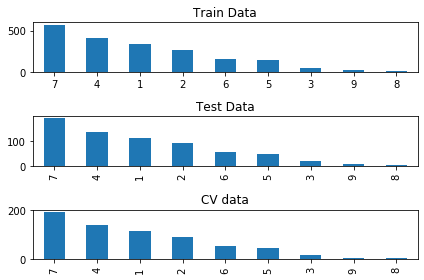

In [161]:
plt.subplot(311)

plt.title('Train Data')
xtrain['Class'].value_counts().plot(kind='bar',rot=0)
plt.subplot(312)

plt.title('Test Data')
xtest['Class'].value_counts().plot(kind='bar')
plt.subplot(313)

plt.title('CV data')
xcv['Class'].value_counts().plot(kind='bar')
plt.tight_layout()
plt.show()



In [162]:
xtrain["text_num_words"] = xtrain["text"].apply(lambda x: len(str(x).split()) )


In [158]:
#xtrain.sort_values(["ID"], axis=0,ascending=[True], inplace=True) 

In [163]:
xtrain.head()

,ID,Gene,Variation,Class,text,text_num_words
3133,3133,KRAS,A146T,7,transforming mutations nras kras thought play ...,11035
1570,1570,ALK,H694R,7,oncogenic property anaplastic lymphoma kinase ...,4825
3258,3258,RET,A883T,7,ret protooncogene mutations responsible multip...,5719
231,231,EGFR,E746_A750delinsQ,7,non small cell lung cancer leading cause death...,11254
468,468,TP53,K291Q,1,tumor suppressor p53 dependent apoptosis thoug...,6582


Unique genes : 222


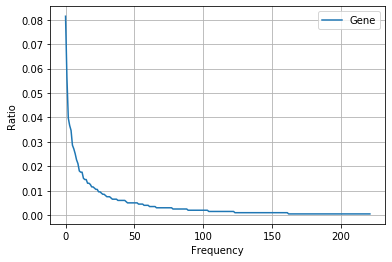

In [167]:
g=xtrain['Gene'].value_counts()
print('Unique genes :',len(g))
s=sum(g.values)
h=g.values/s
plt.plot(h,label='Gene')
plt.xlabel('Frequency')
plt.ylabel('Ratio')
plt.grid()
plt.legend()
plt.show()

# **Helper functions**  for Models

In [338]:
def plot_hyperprm(log_error,alpha,data,cv=0,clf=None,doubleparam=None):
    xtrain=data[0]
    xtest=data[1]
    ytrain=data[2]
    ytest=data[3]
    if(cv==1):
      xcv=data[4]
      ycv=data[5]
    
    #[xtrain,xtest,ytrain,ytest,xcv,ycv]
    if doubleparam is not None:
        pass
    else:
        
        fig, ax = plt.subplots()
        ax.plot(alpha,log_error,c='g')
        plt.grid()
        plt.title("Cross Validation Error for each alpha")
        plt.xlabel("Alpha i's")
        plt.ylabel("Error measure")
        plt.show()
    
    
    best_alpha = np.argmin(log_error)
    #print('Best log error and alpha',min(log_error),best_alpha)
    if clf is None:
      clf = SGDClassifier(alpha=alpha[best_alpha], loss='log', random_state=42,penalty='l2')
    #print(type(clf)) 
    clf.fit(xtrain, ytrain)
    c_clf = CalibratedClassifierCV(clf, method="sigmoid")
    c_clf.fit(xtrain, ytrain)
    
    #Traindata
    predict_y = c_clf.predict_proba(xtrain)
    ltrain=log_loss(ytrain, predict_y, labels=clf.classes_)
    print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",ltrain)
    
    #CVdata
    if(cv==1):
      predict_y =c_clf.predict_proba(xcv)
      lcv=log_loss(ycv,predict_y, labels=clf.classes_)
      print('For values of best alpha = ', alpha[best_alpha], "The CV log loss is:",lcv)
    
    #TestData
    predict_y =c_clf.predict_proba(xtest)
    ltest=log_loss(ytest, predict_y, labels=clf.classes_)
    print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",ltest)
    
    #print(predict_y.shape,len(ytest))
    predicted_y =np.argmax(predict_y,axis=1)
    print("Total number of data points :", len(predicted_y))
    #print('Penalty is ',penal)
    #print(len(ytest))
    #/yy.shape[0]
    pred_y=c_clf.predict(xcv)
    
    print("Number of mis-classified points :", np.count_nonzero((pred_y-ycv))/ycv.shape[0],'\n')
    plot_confusion_matrix(ycv, pred_y)
    

In [209]:
def model_make(clf,xtrain,ytrain,xcv,ycv,log_error):
    clf.fit(xtrain,ytrain)
    c_clf=CalibratedClassifierCV(clf)
    c_clf.fit(xtrain,ytrain)
    pred_y=c_clf.predict_proba(xcv)
    logloss=log_loss(ycv,pred_y,labels=clf.classes_)
    log_error.append(logloss)
    print('Log loss for alpha = "{}" is "{}"'.format(a,logloss))
    return log_error

In [179]:
def analysis(xtrain,xtest,xcv,feat):
  
  #xtrain[str(feat)]
  numtrain=len(xtrain[feat].value_counts())
  numtest=xtest[xtest[feat].isin(list(set(xtrain[feat])))].shape[0]
  numcv=xcv[xcv[feat].isin(list(set(xtrain[feat])))].shape[0]
  print('Total unique {} in xtrain {}'.format(feat,numtrain))
  print('{} data in Cv {} out of {}'.format(feat,numcv,xcv.shape[0]))
  print('{} data in Test {} out of {}'.format(feat,numtest,xtest.shape[0]))
  
  

**Logistic Regression with Gene**

In [ ]:
#CreatingCountVect / 1-hot encoder for gene

countv=CountVectorizer()
onehot_train_gene=countv.fit_transform(xtrain['Gene'])
onehot_test_gene=countv.transform(xtest['Gene'])
onehot_cv_gene=countv.transform(xcv['Gene'])
print(onehot_train_gene.shape,onehot_cv_gene.shape,onehot_test_gene.shape)

Log loss for alpha = "0.0001" is "1.1808463285554391"
Log loss for alpha = "0.001" is "1.2193166914350488"
Log loss for alpha = "0.01" is "1.338622031977288"
Log loss for alpha = "0.1" is "1.4398239850579646"
Log loss for alpha = "1" is "1.4804383887263317"
Log loss for alpha = "10" is "1.4856109810213578"
Log loss for alpha = "100" is "1.4862691231293166"
Log loss for alpha = "1000" is "1.486399563049505"


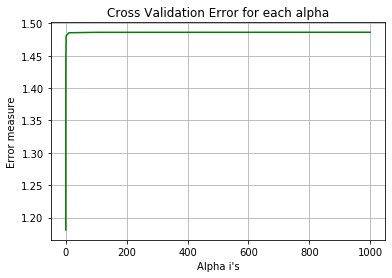

For values of best alpha =  0.0001 The train log loss is: 1.0202572360042825
For values of best alpha =  0.0001 The CV log loss is: 1.1808463285554391
For values of best alpha =  0.0001 The test log loss is: 1.187802106295682
(663, 9) 663
Total number of data points : 663
Number of mis-classified points : 0.45933734939759036 

Total unique Gene in xtrain 222
Gene data in Cv 641 out of 664
Gene data in Test 635 out of 663


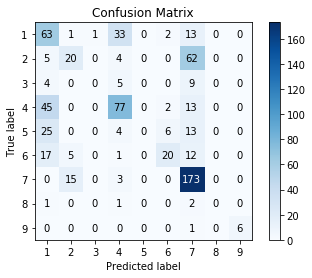

In [334]:
alpha=[10**x for x in range(-4,4)]

log_error=[]
for a in alpha:
    clf=SGDClassifier(loss='log',alpha=a,random_state=42)
    log_e=model_make(clf,onehot_train_gene,ytrain,onehot_cv_gene,ycv,log_error)


plot_hyperprm(log_e,alpha,data=[onehot_train_gene,onehot_test_gene,ytrain,ytest,onehot_cv_gene,ycv],cv=1)
analysis(xtrain,xtest,xcv,'Gene')

**Univariate : Variation**

Number of unique variations: 1818


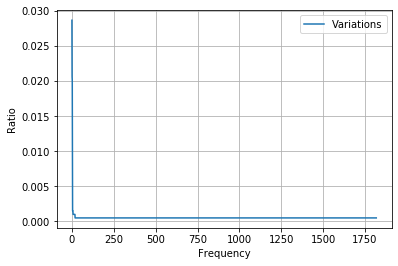

In [181]:
uni=xtrain['Variation'].value_counts()
print('Number of unique variations:',len(uni))
s=sum(uni.values)
h=uni.values/s
plt.plot(h,label='Variations')
plt.legend()
plt.xlabel('Frequency')
plt.ylabel('Ratio')
plt.grid()
plt.show()

In [182]:
#CreatingCountVect / 1-hot encoder for Variation

countv=CountVectorizer()
onehot_train_var=countv.fit_transform(xtrain['Variation'])
onehot_test_var=countv.transform(xtest['Variation'])
onehot_cv_var=countv.transform(xcv['Variation'])
print(onehot_train_var.shape,onehot_cv_var.shape,onehot_test_var.shape)

(1989, 1851) (664, 1851) (663, 1851)


Log loss for alpha = "0.0001" is "1.7173538259091148"
Log loss for alpha = "0.001" is "1.7203632626627507"
Log loss for alpha = "0.01" is "1.7378736940287107"
Log loss for alpha = "0.1" is "1.7463952212372853"
Log loss for alpha = "1" is "1.7471417492440418"
Log loss for alpha = "10" is "1.7472042736538955"
Log loss for alpha = "100" is "1.7472113467380697"
Log loss for alpha = "1000" is "1.7487533434543587"


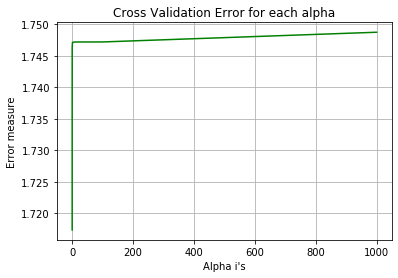

For values of best alpha =  0.0001 The train log loss is: 0.7552240819288899
For values of best alpha =  0.0001 The CV log loss is: 1.7173538259091148
For values of best alpha =  0.0001 The test log loss is: 1.7086286511233235
Total number of data points : 663
Number of mis-classified points : 0.6641566265060241 

Total unique Variation in xtrain 1818
Variation data in Cv 64 out of 664
Variation data in Test 81 out of 663
Wall time: 1.77 s


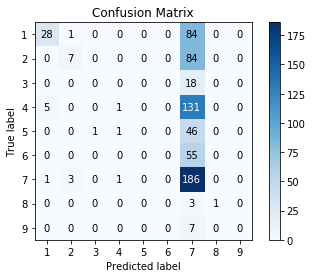

In [343]:
%%time
#building singular Model for Variation feature
alpha=[10**x for x in range(-4,4)]

log_error=[]
for a in alpha:
  clf=SGDClassifier(loss='log',alpha=a,random_state=42)
  log_e=model_make(clf,onehot_train_var,ytrain,onehot_cv_var,ycv,log_error)
  
plot_hyperprm(log_e,alpha,data=[onehot_train_var,onehot_test_var,ytrain,ytest,onehot_cv_var,ycv],cv=1)
analysis(xtrain,xtest,xcv,'Variation')

# **Univariate : Text**

In [185]:
#tfidf.shape
#trunc_tfid.shape
#Using tfidf
Text_vectoriser=TfidfVectorizer()
tfidf_train=Text_vectoriser.fit_transform(xtrain['text'])
tfidf_test=Text_vectoriser.transform(xtest['text'])
tfidf_cv=Text_vectoriser.transform(xcv['text'])
svd = TruncatedSVD(n_components=25, n_iter=100, random_state=12)
trunctf_train=svd.fit_transform(tfidf_train)
trunctf_test=svd.fit_transform(tfidf_test)
trunctf_cv=svd.fit_transform(tfidf_cv)

Log loss for alpha = "0.0001" is "1.8313663884851357"
Log loss for alpha = "0.001" is "1.747932989385219"
Log loss for alpha = "0.01" is "1.7040142033304548"
Log loss for alpha = "0.1" is "1.6791095114787487"
Log loss for alpha = "1" is "1.6772035611237683"
Log loss for alpha = "10" is "1.7099598804648457"
Log loss for alpha = "100" is "1.7299810208968076"
Log loss for alpha = "1000" is "1.7339590271662153"


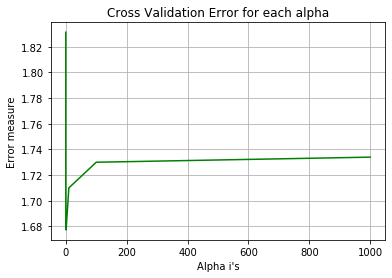

For values of best alpha =  1 The train log loss is: 1.4245926006669267
For values of best alpha =  1 The CV log loss is: 1.6772035611237683
For values of best alpha =  1 The test log loss is: 1.5390451486550965
(663, 9) 663
Total number of data points : 663
Number of mis-classified points : 0.661144578313253 



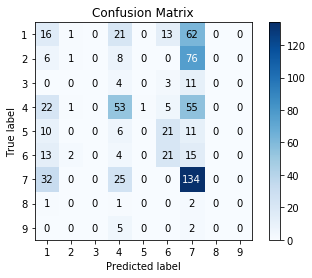

In [273]:

#building singular Model for Text feature -Truncated
alpha=[10**x for x in range(-4,4)]

log_error=[]
for a in alpha:
  clf=SGDClassifier(loss='log',alpha=a,random_state=42)
  log_e=model_make(clf,trunctf_train,ytrain,trunctf_cv,ycv,log_error)
  
plot_hyperprm(log_e,alpha,data=[trunctf_train,trunctf_test,ytrain,ytest,trunctf_cv,ycv],cv=1)
#analysis(xtrain,xtest,xcv,'Variation')

Log loss for alpha = "500" is "1.66632466375166"
Log loss for alpha = "1000" is "1.6587696299994843"
Log loss for alpha = "1500" is "1.6606972856256352"
Log loss for alpha = "2000" is "1.661501386920355"


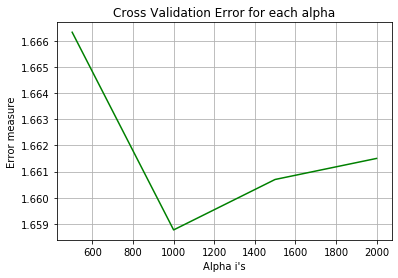

For values of best alpha =  1000 The train log loss is: 1.10860662262339
For values of best alpha =  1000 The CV log loss is: 1.6676580631609428
For values of best alpha =  1000 The test log loss is: 1.592058159472696
(663, 9) 663
Total number of data points : 663
Number of mis-classified points : 0.6566265060240963 



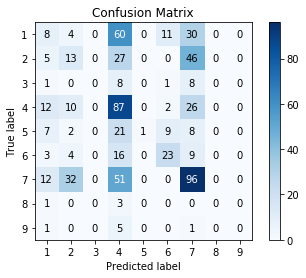

In [274]:
#building singular Model for text feature truncated random forest
alpha=[500,1000,1500,2000]

log_error=[]

for a in alpha:
  clf=RandomForestClassifier(n_estimators=a, max_depth=5)
  log_e=model_make(clf,trunctf_train,ytrain,trunctf_cv,ycv,log_error)
clf=RandomForestClassifier(n_estimators=alpha[np.argmin(log_e)], max_depth=5,random_state=42)
plot_hyperprm(log_e,alpha,data=[trunctf_train,trunctf_test,ytrain,ytest,trunctf_cv,ycv],cv=1,clf=clf)

Log loss for alpha = "0.0001" is "1.0539363188239104"
Log loss for alpha = "0.001" is "1.1248321967120805"
Log loss for alpha = "0.01" is "1.3027630589173036"
Log loss for alpha = "0.1" is "1.5450241775317402"
Log loss for alpha = "1" is "1.6097613509850615"
Log loss for alpha = "10" is "1.616696381616254"
Log loss for alpha = "100" is "1.6175237769219828"
Log loss for alpha = "1000" is "1.6176738413093725"


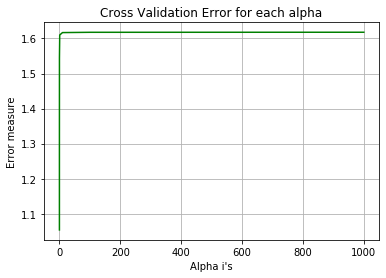

For values of best alpha =  0.0001 The train log loss is: 0.6775248386637014
For values of best alpha =  0.0001 The CV log loss is: 1.0539363188239104
For values of best alpha =  0.0001 The test log loss is: 1.0061614257325877
Total number of data points : 663
Number of mis-classified points : 0.35843373493975905 

Wall time: 41.5 s


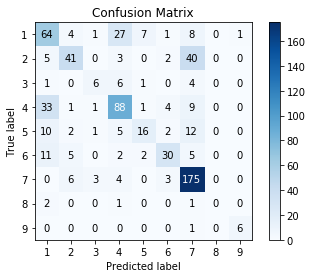

In [345]:
%%time
#building singular Model for Text feature with tfidf
alpha=[10**x for x in range(-4,4)]

log_error=[]
for a in alpha:
  clf=SGDClassifier(loss='log',alpha=a,random_state=42)
  log_e=model_make(clf,tfidf_train,ytrain,tfidf_cv,ycv,log_error)
  
plot_hyperprm(log_error,alpha,data=[tfidf_train,tfidf_test,ytrain,ytest,tfidf_cv,ycv],cv=1)
#analysis(xtrain,xtest,xcv,'Variation')

# Model Building

In [189]:
print('Gene:\n  train :{} \t cv:{} \t test:{}\n'.format(onehot_train_gene.shape,onehot_cv_gene.shape,onehot_test_gene.shape))
print('Variation:\n  train :{} \t cv:{} \t test:{}\n'.format(onehot_train_var.shape,onehot_cv_var.shape,onehot_test_var.shape))
print('Text:\n  train :{} \t cv:{} \t test:{}\n'.format(tfidf_train.shape,tfidf_cv.shape,tfidf_test.shape))

Gene:
  train :(1989, 222) 	 cv:(664, 222) 	 test:(663, 222)

Variation:
  train :(1989, 1851) 	 cv:(664, 1851) 	 test:(663, 1851)

Text:
  train :(1989, 122331) 	 cv:(664, 122331) 	 test:(663, 122331)



In [190]:
#Step 1 : Combining data set

#train=onehot_train_gene+onehot_train_var+tfidf_train

#gene_var=np.hstack((onehot_train_gene,onehot_train_var))

genevar=hstack((onehot_train_gene,onehot_train_var))
x_train=hstack((genevar,tfidf_train)).tocsr()
y_train=np.array(ytrain)

genevar=hstack((onehot_cv_gene,onehot_cv_var))
x_cv=hstack((genevar,tfidf_cv)).tocsr()
y_cv=np.array(ycv)

genevar=hstack((onehot_test_gene,onehot_test_var))
x_test=hstack((genevar,tfidf_test.shape)).tocsr()
y_test=np.array(ytest)

In [192]:

print('xtrain:{} \t xcv:{} \t xtest:{} \n'.format(x_train.shape,x_cv.shape,x_test.shape))

xtrain:(1989, 124404) 	 xcv:(664, 124404) 	 xtest:(663, 124404) 



Log loss for alpha = "0.0001" is "0.9878707455016754"
Log loss for alpha = "0.001" is "1.026561412506568"
Log loss for alpha = "0.01" is "1.1751642113109382"
Log loss for alpha = "0.1" is "1.3945076928524998"
Log loss for alpha = "1" is "1.4909075091722737"
Log loss for alpha = "10" is "1.504086466364456"
Log loss for alpha = "100" is "1.5056486254620636"
Log loss for alpha = "1000" is "1.5059225458165684"


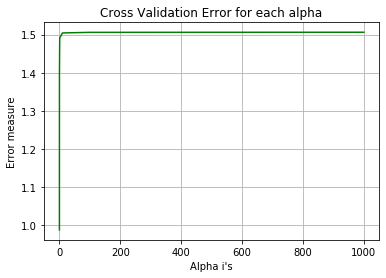

For values of best alpha =  0.0001 The train log loss is: 0.42198018425463973
For values of best alpha =  0.0001 The CV log loss is: 0.9878707455016754
For values of best alpha =  0.0001 The test log loss is: 1.2958962523676238
(663, 9) 663
Total number of data points : 663
Number of mis-classified points : 0.34036144578313254 



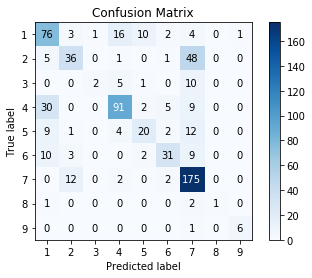

In [276]:
#Weighted Logistic Regression
alpha=[10**x for x in range(-4,4)]

log_error=[]

for a in alpha:
  clf=SGDClassifier(loss='log',alpha=a,random_state=42,class_weight='balanced')
  log_error=model_make(clf,x_train,y_train,x_cv,y_cv,log_error)

clf=SGDClassifier(loss='log',alpha=alpha[np.argmin(log_error)],random_state=42,class_weight='balanced')
plot_hyperprm(log_error,alpha,data=[x_train,x_test,y_train,y_test,x_cv,y_cv],cv=1,clf=clf)


Log loss for alpha = "0.0001" is "1.0433629804666724"
Log loss for alpha = "0.001" is "1.079905654638363"
Log loss for alpha = "0.01" is "1.2491122902524285"
Log loss for alpha = "0.1" is "1.4402713037520933"
Log loss for alpha = "1" is "1.5061478966828694"
Log loss for alpha = "10" is "1.5061479121098384"
Log loss for alpha = "100" is "1.5061478976281681"
Log loss for alpha = "1000" is "1.5061194025237128"


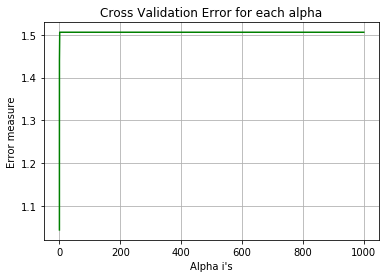

For values of best alpha =  0.0001 The train log loss is: 0.4001257691280621
For values of best alpha =  0.0001 The CV log loss is: 1.0433629804666724
For values of best alpha =  0.0001 The test log loss is: 1.3808410175467511
(663, 9) 663
Total number of data points : 663
Number of mis-classified points : 0.3569277108433735 



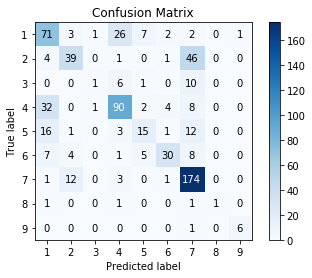

In [277]:
#LinearSVM

alpha=[10**x for x in range(-4,4)]
log_error=[]
for a in alpha:
    clf = SGDClassifier( class_weight='balanced', alpha=a, penalty='l2', loss='hinge', random_state=42)
    log_e=model_make(clf,x_train,y_train,x_cv,y_cv,log_error)
clf=SGDClassifier(class_weight='balanced',alpha=alpha[np.argmin(log_e)],loss='hinge',random_state=42)
plot_hyperprm(log_e,alpha,data=[x_train,x_test,y_train,y_test,x_cv,y_cv],cv=1,clf=clf)



Depth: 5 Estimators: 500
Log loss for alpha = "500" is "1.1757889154627554"
Depth: 10 Estimators: 500
Log loss for alpha = "500" is "1.0944218207028897"
Depth: 5 Estimators: 1000
Log loss for alpha = "1000" is "1.164294664949823"
Depth: 10 Estimators: 1000
Log loss for alpha = "1000" is "1.095344485997923"
For values of best alpha =  1000 The train log loss is: 0.6782768806203672
For values of best alpha =  1000 The CV log loss is: 1.0971148246995752
For values of best alpha =  1000 The test log loss is: 2.070799315781042
(663, 9) 663
Total number of data points : 663
Number of mis-classified points : 0.3373493975903614 



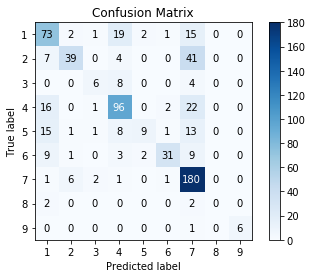

In [337]:

alpha=[500,1000]
depth=[5,10]
log_error=[]

for a in alpha:
    for d in depth:
      clf=RandomForestClassifier(n_estimators=a, max_depth=d)
      print('Depth:',d,'Estimators:',a)
      log_e=model_make(clf,x_train,y_train,x_cv,y_cv,log_error)
b=np.argmin(log_e)
clf=RandomForestClassifier(n_estimators=alpha[int(b/2)], max_depth=depth[int(b%2)],random_state=42)
plot_hyperprm(log_e,alpha,data=[x_train,x_test,y_train,y_test,x_cv,y_cv],cv=1,clf=clf,doubleparam=depth)

Depth: 5 Estimators: 500
Log loss for alpha = "500" is "2.0352929570943075"
Depth: 10 Estimators: 500
Log loss for alpha = "500" is "1.9959197930307349"
Depth: 5 Estimators: 1000
Log loss for alpha = "1000" is "2.0488204222750457"
Depth: 10 Estimators: 1000
Log loss for alpha = "1000" is "2.008854818589795"
For values of best alpha =  1000 The train log loss is: 0.6652868407589821
For values of best alpha =  1000 The CV log loss is: 2.0047771289581466
For values of best alpha =  1000 The test log loss is: 2.1772229368441733
Total number of data points : 663
Number of mis-classified points : 0.7620481927710844 



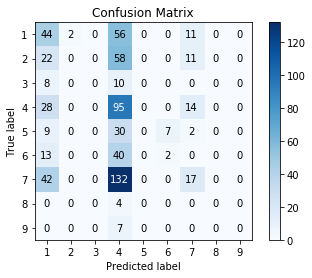

In [339]:
svd = TruncatedSVD(n_components=25, n_iter=100, random_state=12)
truncx_train=svd.fit_transform(x_train)
truncx_test=svd.fit_transform(x_test)
truncx_cv=svd.fit_transform(x_cv)

alpha=[500,1000]
depth=[5,10]
log_error=[]

for a in alpha:
    for d in depth:
      clf=RandomForestClassifier(n_estimators=a, max_depth=d)
      print('Depth:',d,'Estimators:',a)
      log_e=model_make(clf,truncx_train,y_train,truncx_cv,y_cv,log_error)
b=np.argmin(log_e)
clf=RandomForestClassifier(n_estimators=alpha[int(b/2)], max_depth=depth[int(b%2)],random_state=42)
plot_hyperprm(log_e,alpha,data=[truncx_train,truncx_test,y_train,y_test,truncx_cv,y_cv],cv=1,clf=clf,doubleparam=depth)